# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [20]:
#Loading all libs at once
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import pickle
from matplotlib.pyplot import inferno


In [21]:
FILE_PATH = '../../05_src/data/fires/forestfires.csv'

COLUMNS = ['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']

FIRES_DT = pd.read_csv(FILE_PATH, header=0, names=COLUMNS)

FIRES_DT


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [22]:
#Further ETL
FIRES_DT['month'] = FIRES_DT['month'].astype('category')
FIRES_DT['day'] = FIRES_DT['day'].astype('category')
FIRES_DT.ffill(inplace=True)
FIRES_DT.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   coord_x  517 non-null    int64   
 1   coord_y  517 non-null    int64   
 2   month    517 non-null    category
 3   day      517 non-null    category
 4   ffmc     517 non-null    float64 
 5   dmc      517 non-null    float64 
 6   dc       517 non-null    float64 
 7   isi      517 non-null    float64 
 8   temp     517 non-null    float64 
 9   rh       517 non-null    int64   
 10  wind     517 non-null    float64 
 11  rain     517 non-null    float64 
 12  area     517 non-null    float64 
dtypes: category(2), float64(8), int64(3)
memory usage: 46.3 KB


# Get X and Y

Create the features data frame and target data.

In [23]:
# Separate features and target
FEATURES = FIRES_DT.drop(columns=['area'])
TARGET = FIRES_DT['area']

# Ensure all categorical features are converted to numeric
FEATURES = pd.get_dummies(FEATURES, columns=['month', 'day'], drop_first=True)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(FEATURES, TARGET, test_size=0.3, random_state=42)

# Define numerical features
NUMERICAL_COLS = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()


In [24]:
NUMERICAL_COLS


['coord_x',
 'coord_y',
 'ffmc',
 'dmc',
 'dc',
 'isi',
 'temp',
 'rh',
 'wind',
 'rain']

In [25]:
FEATURES


,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,False,False,False,False,False,False,False,False,False,False
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,False,False,True,False,False,False,False,False,True,False
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,False,False,True,False,False,True,False,False,False,False
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,False,False,False,False,False,False,False,False,False,False
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,False,False,False,False,False,False,True,False,False,False
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,False,False,False,False,False,False,True,False,False,False
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,False,False,False,False,False,False,True,False,False,False
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,False,False,False,False,False,True,False,False,False,False


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [26]:
SCALERS = {
    'std': StandardScaler(),
    'robust': RobustScaler(),
    'minmax': MinMaxScaler()
}

SCALERS


{'std': StandardScaler(), 'robust': RobustScaler(), 'minmax': MinMaxScaler()}

In [27]:
#Creating preprocessing pipelines
PREPROC1 = ColumnTransformer(
    transformers=[
        ('num_std', SCALERS['std'], NUMERICAL_COLS)
    ],
    remainder='passthrough'
)

PREPROC1


ColumnTransformer(remainder='passthrough',
                  transformers=[('num_std', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain'])])

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [28]:
PREPROC2 = ColumnTransformer(
    transformers=[
        ('num_std', Pipeline([
            ('scaler', SCALERS['std']),
            ('non_linear', PowerTransformer())
        ]), NUMERICAL_COLS)
    ],
    remainder='passthrough'
)

PREPROC2


ColumnTransformer(remainder='passthrough',
                  transformers=[('num_std',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('non_linear',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [29]:
#Define the baseline and advanced regressors
BASELINE_REGRESSOR = LinearRegression()
BASELINE_REGRESSOR


LinearRegression()

In [30]:
ADVANCED_REGRESSOR = RandomForestRegressor()
ADVANCED_REGRESSOR


RandomForestRegressor()

In [31]:
#Pipelines:
PIPELINES = {
    'pipeline_A': Pipeline(steps=[('preprocessing', PREPROC1), ('regressor', BASELINE_REGRESSOR)]),
    'pipeline_B': Pipeline(steps=[('preprocessing', PREPROC2), ('regressor', BASELINE_REGRESSOR)]),
    'pipeline_C': Pipeline(steps=[('preprocessing', PREPROC1), ('regressor', ADVANCED_REGRESSOR)]),
    'pipeline_D': Pipeline(steps=[('preprocessing', PREPROC2), ('regressor', ADVANCED_REGRESSOR)])
}


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [32]:
#GridSearchCV
PARAM_GRIDS = {
    'pipeline_A': {'regressor__fit_intercept': [True, False]},
    'pipeline_B': {'regressor__fit_intercept': [True, False]},
    'pipeline_C': {'regressor__n_estimators': [100, 200, 300], 'regressor__max_depth': [None, 10, 20]},
    'pipeline_D': {'regressor__n_estimators': [100, 200, 300], 'regressor__max_depth': [None, 10, 20]}
}


In [33]:
#GridSearchCV for each pipeline
GRID_SEARCHES = {}
for name, pipeline in PIPELINES.items():
    grid_search = GridSearchCV(
        pipeline, PARAM_GRIDS[name], cv=5, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)
    GRID_SEARCHES[name] = grid_search
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best cross-validation score for {name}: {grid_search.best_score_}')


Best parameters for pipeline_A: {'regressor__fit_intercept': True}
Best cross-validation score for pipeline_A: -2526.1689113127895
Best parameters for pipeline_B: {'regressor__fit_intercept': False}
Best cross-validation score for pipeline_B: -2441.7858158777854
Best parameters for pipeline_C: {'regressor__max_depth': None, 'regressor__n_estimators': 100}
Best cross-validation score for pipeline_C: -2961.7216958870317
Best parameters for pipeline_D: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Best cross-validation score for pipeline_D: -2967.0828677039117


# Evaluate

+ Which model has the best performance?<br>
* *Answer:* The best model is the one with the highest (least negative) cross-validation score, as it indicates the lowest MSE and the Pipeline A is the best one.


In [34]:
#Best scores for each pipeline
SCORES = {name: grid_search.best_score_ for name,
          grid_search in GRID_SEARCHES.items()}
SCORES


{'pipeline_A': -2526.1689113127895,
 'pipeline_B': -2441.7858158777854,
 'pipeline_C': -2961.7216958870317,
 'pipeline_D': -2967.0828677039117}

In [35]:
#Best performing pipeline
BEST_PIPELINE_NAME = max(SCORES, key=SCORES.get)
BEST_PIPELINE_SCORE = SCORES[BEST_PIPELINE_NAME]

print(f'The best performing pipeline is {BEST_PIPELINE_NAME} with a score of {BEST_PIPELINE_SCORE}')

BEST_MODEL = GRID_SEARCHES[BEST_PIPELINE_NAME].best_estimator_


The best performing pipeline is pipeline_B with a score of -2441.7858158777854


# Export

 + Save the best performing model to a pickle file.



In [36]:
#Saving the best model to a pickle file
FILE = '../../06_output/data/Forest_Fires/best_model.pkl'
with open(FILE, 'wb') as file:
	pickle.dump(BEST_MODEL, file)

print('The best model has been saved to best_model.pkl')


The best model has been saved to best_model.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

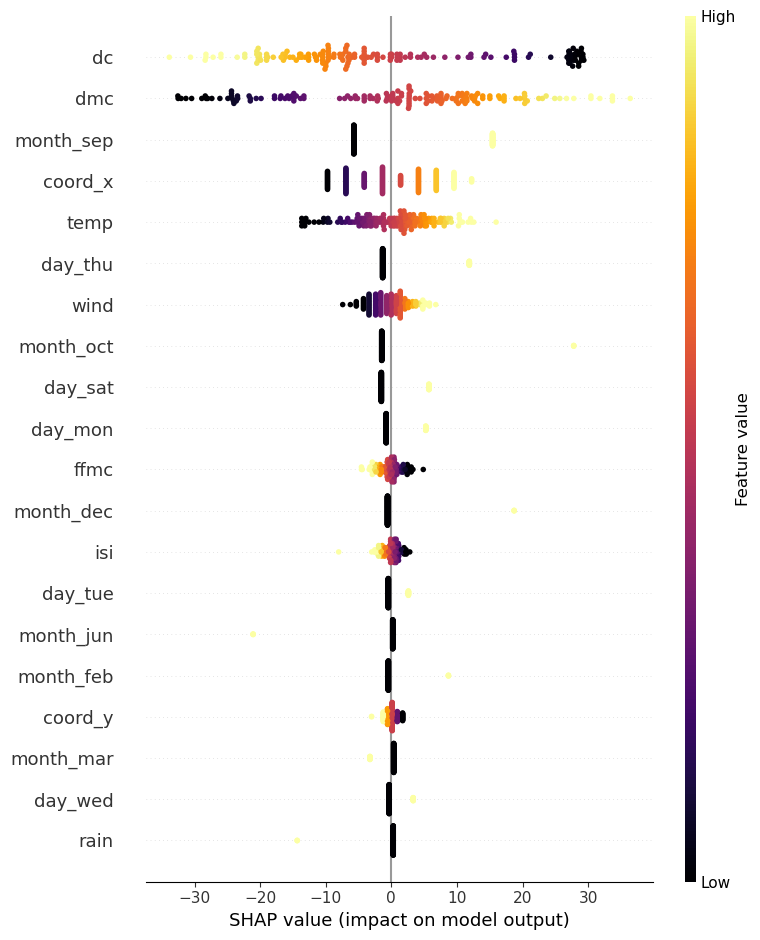

In [37]:
X_TEST_TRANSFORMED = BEST_MODEL.named_steps['preprocessing'].transform(X_test)

# Initialize the SHAP explainer with feature names
EXPLAINER = shap.Explainer(
    BEST_MODEL.named_steps['regressor'], X_TEST_TRANSFORMED, feature_names=X_test.columns)

# Compute SHAP values for the entire test set
SHAP_VALUES_ALL = EXPLAINER(X_TEST_TRANSFORMED)

# Summary plot to show feature importance
shap.summary_plot(SHAP_VALUES_ALL, X_TEST_TRANSFORMED,
                  feature_names=X_test.columns, cmap="inferno")


# My answers

* Two important indexes are in evidence in this chart such as 'dc' and 'dmc' which stands for the Drought Code and Duff Moisture Code respectively. These features tend to increase the fire area but we can't forget about variables such as 'temp' (temperature) and 'month' which brings influence in some extent. The color hue define the degree of importance of the feature's value where color varying from dark to bright varies from low to high values in which are directly proportionmal to the degree of importance.<br><br>
* It is also important to mention that the more aglutinated dots below and / or above zero means that it will decrease of increase the prediction size.<br><br>
* The other features with low SHAP values could possibly be removed from the model (which simplifies it) allowing the model being more simplified.<br><br>
* Answering the question if I would remove features, them I would:<br><br>
	* Remove the least ones (low influence)
	* Compare the old with the new one in terms of metrics
	* Work on cross-validation to ensure performance estability
	* Observe the new SHAP plot and see how the new features are contributing with the new model


## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [X] Created a branch with the correct naming convention.
- [X] Ensured that the repository is public.
- [X] Reviewed the PR description guidelines and adhered to them.
- [X] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.